
# Telco Customer Churn — Jupyter Notebook

This notebook runs the full assignment workflow end‑to‑end in **Jupyter**:

1. Install dependencies
2. Load & clean the Telco dataset (`WA_Fn-UseC_-Telco-Customer-Churn.csv`)
3. Build preprocessing (OneHot for categoricals, scale numerics)
4. Train **6 models** (LogReg, DecisionTree, kNN, NaiveBayes, RandomForest, XGBoost/GB)
5. Evaluate with **Accuracy, AUC, Precision, Recall, F1, MCC**
6. Plot confusion matrix; show classification report
7. Save models and metrics for the Streamlit app (optional)


In [12]:

# 1) Install dependencies (uncomment if needed)
# %pip install -q scikit-learn xgboost pandas numpy matplotlib seaborn joblib


In [13]:

import os, json, joblib
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

DATA_PATH = Path('WA_Fn-UseC-Telco-Customer-Churn.csv')
assert DATA_PATH.exists(), f"Dataset not found at {DATA_PATH}. Place the CSV in this directory."


In [14]:

# 2) Load & Clean

df = pd.read_csv(DATA_PATH)
df.columns = [c.strip() for c in df.columns]
if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])

tc = pd.to_numeric(
    df['TotalCharges'].astype(str).str.strip().replace({'': np.nan}),
    errors='coerce'
)

# 2) Compute median on the numeric series
tc_median = tc.median(skipna=True)

# 3) Fill NaNs with the numeric median, then assign back
df['TotalCharges'] = tc.fillna(tc_median)

# Target to 0/1
assert 'Churn' in df.columns, 'Target column Churn not found.'
df['Churn'] = df['Churn'].astype(str).str.strip().str.lower().map({'yes':1,'no':0})

print(df.shape)
df.head()


(7043, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [15]:

# 3) Preprocessing

X = df.drop(columns=['Churn'])
y = df['Churn'].astype(int)

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

len(num_cols), len(cat_cols)


(4, 15)

In [16]:

# 4) Models
MODELS = {
    'Logistic Regression': LogisticRegression(max_iter=200),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'kNN': KNeighborsClassifier(n_neighbors=7),
    'Naive Bayes (Gaussian)': GaussianNB(),
    'Random Forest (Ensemble)': RandomForestClassifier(n_estimators=300, random_state=42),
}
if HAS_XGB:
    MODELS['XGBoost (Ensemble)'] = XGBClassifier(n_estimators=400, max_depth=5, learning_rate=0.05,
                                                 subsample=0.9, colsample_bytree=0.9, eval_metric='logloss',
                                                 random_state=42)
else:
    MODELS['XGBoost (Ensemble)'] = GradientBoostingClassifier(random_state=42)


In [17]:

# 5) Train, evaluate, and collect metrics

metrics_rows = []
reports = {}

for name, model in MODELS.items():
    pipe = Pipeline(steps=[('prep', preprocessor), ('model', model)])
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    # Probabilities for AUC (if available)
    y_proba = None
    if hasattr(pipe, 'predict_proba'):
        try:
            y_proba = pipe.predict_proba(X_test)[:,1]
        except Exception:
            y_proba = None
    elif hasattr(pipe, 'decision_function'):
        scores = pipe.decision_function(X_test)
        scores = (scores - scores.min())/(scores.max()-scores.min()+1e-9)
        y_proba = scores

    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    mcc = matthews_corrcoef(y_test, y_pred)

    metrics_rows.append([
        name, round(acc,4), round(auc,4) if not np.isnan(auc) else None,
        round(prec,4), round(rec,4), round(f1,4), round(mcc,4)
    ])

    reports[name] = {
        'confusion_matrix': confusion_matrix(y_test, y_pred).tolist(),
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }

columns = ['ML Model Name','Accuracy','AUC','Precision','Recall','F1','MCC']
metrics_df = pd.DataFrame(metrics_rows, columns=columns)
metrics_df.sort_values('AUC', ascending=False, inplace=True)
metrics_df


,ML Model Name,Accuracy,AUC,Precision,Recall,F1,MCC
5,XGBoost (Ensemble),0.8062,0.8432,0.6735,0.5241,0.5895,0.4715
0,Logistic Regression,0.8055,0.8419,0.6572,0.5588,0.6040,0.4790
4,Random Forest (Ensemble),0.7779,0.8173,0.6048,0.4706,0.5293,0.3921
3,Naive Bayes (Gaussian),0.6948,0.8074,0.4589,0.8369,0.5928,0.4245
2,kNN,0.7644,0.8047,0.5544,0.5722,0.5632,0.4020
1,Decision Tree,0.7289,0.6573,0.4896,0.5053,0.4974,0.3119


Best by AUC: XGBoost (Ensemble)


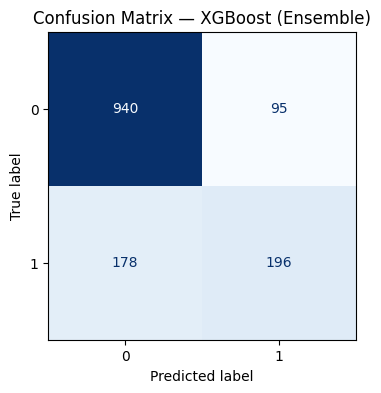

In [18]:

# 6) Visuals: confusion matrix of best model by AUC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

best_name = metrics_df.iloc[0]['ML Model Name']
print('Best by AUC:', best_name)

# Refit best for plotting (keeps code simple)
best_model = MODELS[best_name]
pipe_best = Pipeline(steps=[('prep', preprocessor), ('model', best_model)])
pipe_best.fit(X_train, y_train)
y_pred_best = pipe_best.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)
fig, ax = plt.subplots(figsize=(4,4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title(f'Confusion Matrix — {best_name}')
plt.show()


In [19]:

# 7) Save models and metrics for Streamlit app (optional)
Path('models').mkdir(exist_ok=True)

for name, model in MODELS.items():
    pipe = Pipeline(steps=[('prep', preprocessor), ('model', model)])
    pipe.fit(X_train, y_train)
    safe = name.lower().replace(' ','_').replace('(','').replace(')','').replace('/','_')
    joblib.dump(pipe, Path('models')/f'{safe}.joblib')

metrics_df.to_json(Path('models')/'metrics.json', orient='records', indent=2)
with open(Path('models')/'reports.json', 'w') as f:
    json.dump(reports, f, indent=2)

print('Saved models and metrics to ./models/')


Saved models and metrics to ./models/
